In [1]:
import picos as pc
import qics as qc
from qics.cones import OpPerspecEpi
import numpy as np
from scipy.sparse import csr_array, coo_array, block_array
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from collections import Counter
from common import SiteBasis

In [2]:
def basis_commutator(o1, o2):
    commutation_table = [
        [(0, ''),(0, ''),(0, ''),(0, '')],
        [(0, ''),(0, ''),(2, 'Z'),(-2, 'Y')],
        [(0, ''),(-2, 'Z'),(0, ''),(2, 'X')],
        [(0, ''),(2, 'Y'),(-2, 'X'),(0, '')],
    ] # everything here must be multiplied with 1j
    return commutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_anticommutator(o1, o2):
    anticommutation_table = [
        [(2, 'I'),(2, 'X'),(2, 'Y'),(2, 'Z')],
        [(2, 'X'),(2, 'I'),(0, ''),(0, '')],
        [(2, 'Y'),(0, ''),(2, 'I'),(0, '')],
        [(2, 'Z'),(0, ''),(0, ''),(2, 'I')],
    ]
    return anticommutation_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def basis_product(o1, o2):
    product_table = [
        [(1, 'I'),(1, 'X'),(1, 'Y'),(1, 'Z')],
        [(1, 'X'),(1, 'I'),(1j, 'Z'),(-1j, 'Y')],
        [(1, 'Y'),(-1j, 'Z'),(1, 'I'),(1j, 'X')],
        [(1, 'Z'),(1j, 'Y'),(-1j, 'X'),(1, 'I')],
    ]
    return product_table['IXYZ'.find(o1)]['IXYZ'.find(o2)]

def anticommutator(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        c, o = basis_anticommutator(word1, word2)
        return Counter({o: c})
    expression = Counter()
    e_1 = commutator(word1[0], word2[0])
    e_2 = commutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = anticommutator(word1[1:], word2[1:])
    for o1, c1 in e_1.items():
        for o2, c2 in e_2.items():
            expression[o1 + o2] -= 0.5 * c1 * c2 # since c1 * 1j * c2 * 1j = - c1 * c2
    for o1, c1 in e_3.items():
        for o2, c2 in e_4.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    return expression

def commutator(word1: str, word2: str):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    if len(word1) == 1:
        c, o = basis_commutator(word1, word2)
        return Counter({o: c})
    expression = Counter()
    e_1 = commutator(word1[0], word2[0])
    e_2 = anticommutator(word1[1:], word2[1:])
    e_3 = anticommutator(word1[0], word2[0])
    e_4 = commutator(word1[1:], word2[1:])
    for o1, c1 in e_1.items():
        for o2, c2 in e_2.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    for o1, c1 in e_3.items():
        for o2, c2 in e_4.items():
            expression[o1 + o2] += 0.5 * c1 * c2
    # whatever is returned, needs to be multiplied by 1j
    return expression

def product(word1, word2):
    if len(word1) != len(word2):
        raise ValueError(f'{word1} and {word2} do not have same length')
    word = []
    coeff = 1
    for o1, o2 in zip(word1, word2):
        c, op = basis_product(o1, o2)
        word.append(op)
        coeff *= c
    # coeff can be real or complex
    return (coeff, ''.join(word))

Counter({'': 0.0, 'II': 0.0})

<h2>Thermal Transverse Field Ising:</h2>

In [10]:
def schwinger_dyson(x, basis, hamil: list, word1: str):
    expression = Counter()
    constraint = 0
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for op, c in terms.items():
            if len(op) != len(word1):
                continue
            if not np.isclose(np.abs(coeff * c), 0):
                expression[op] += coeff * c
    for op, c in expression.items():
        constraint += c * x[basis.rank(op)]
    return constraint == 0

def normalization(x, basis, L):
    return x[basis.rank('I' * L)] == 1

def kms(basis, x, hamil, A, C):
    ops = basis._ops
    n = len(ops)
    constraints = []
    def get_A_term(i, j):
        coeff, word = product(ops[i], ops[j])
        return coeff * x[basis.rank(word)]
    def get_C_term(i, j):
        expression = 0
        termsd = Counter()
        for coeff, w in hamil:
            terms = commutator(w, ops[j])
            for op, c in terms.items():
                if len(op) != len(w):
                    continue
                c2, op2 = product(ops[i], op)
                termsd[op2] += coeff * c * c2
        for op, coeff in termsd.items():
            if np.isclose(np.abs(coeff), 0):
                continue
            expression += coeff * x[basis.rank(op)]
        return expression * 1j
    for i in range(n):
        for j in range(i, n):
            constraints.extend([A[i, j] == get_A_term(i, j), C[i, j] == get_C_term(i, j)])
    return constraints

In [11]:
def construct_hamil(L, h):
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    return hamil

# Remember that all expectation values are real in the Ising model
def create_problem(L):
    basis = SiteBasis(L)
    n = basis.size()
    H = construct_hamil(L, 1)
    x = pc.RealVariable('op', (n, 1))
    energy = -L * (x[basis.rank('XX'+'I'*(L-2))] + x[basis.rank('Z'+'I'*(L-1))])
    if L == 2:
        energy = -(x[basis.rank('XX')] + 2 * x[basis.rank('Z'+'I'*(L-1))])
    Pmin = pc.Problem('Energy lower bound')
    Pmax = pc.Problem('Energy upper bound')
    Pmin.set_objective("min", energy)
    Pmax.set_objective("max", energy)
    A = pc.HermitianVariable('A', n)
    C = pc.HermitianVariable('C', n)
    # KMS condition
    constraints = []
    constraints.extend(kms(basis, x, H, A, C))
    # Normalization
    constraints.append(normalization(x, basis, L))
    # Schwinger-Dyson
    for i in range(n):
        constraint = schwinger_dyson(x, basis, H, basis.unrank(i))
        if isinstance(constraint, bool):
            continue
        constraints.append(constraint)
    Pmin.add_list_of_constraints(constraints)
    Pmax.add_list_of_constraints(constraints)
    print(Pmin.constraints,sep='\n')
    return Pmin, Pmax, A, C

def solve(L, betas, verbose=True):
    mins,maxs = np.zeros_like(betas), np.zeros_like(betas)
    Pmin, Pmax, A, C = create_problem(L)
    ope = pc.oprelentr(A, A.conj)
    KMS = betas[0] * C >> ope
    Pmin.add_constraint(KMS)
    Pmax.add_constraint(KMS)
    print(Pmin)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        Pmin.solve(solver="qics")
        Pmax.solve(solver="qics")
        E_min = Pmin.value
        E_max = Pmax.value
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
        if i + 1 < len(betas):
            Pmin.remove_constraint(KMS)
            Pmax.remove_constraint(KMS)
            KMS = betas[i + 1] * C >> ope
            Pmin.add_constraint(KMS)
            Pmax.add_constraint(KMS)
    return mins, maxs


In [12]:
betas = 1/np.linspace(0.01, 4, num = 20)
L = 2
mins, maxs = solve(L, betas)

OrderedDict([(774260084, <1×1 Affine Constraint: op[0] = A[0,0]>), (774260085, <1×1 Affine Constraint: C[0,0] = 0j>), (774260086, <1×1 Complex Equality Constraint: A[0,1] = op[1]>), (774260087, <1×1 Complex Equality Constraint: C[0,1] = -2·op[2]·1j>), (774260088, <1×1 Complex Equality Constraint: A[0,2] = op[2]>), (774260089, <1×1 Complex Equality Constraint: C[0,2] = (2·op[1] - 2·op[7])·1j>), (774260090, <1×1 Complex Equality Constraint: A[0,3] = op[3]>), (774260091, <1×1 Complex Equality Constraint: C[0,3] = 2·op[6]·1j>), (774260092, <1×1 Complex Equality Constraint: A[0,4] = op[4]>), (774260093, <1×1 Complex Equality Constraint: C[0,4] = -2·op[8]·1j>), (774260094, <1×1 Complex Equality Constraint: A[0,5] = op[5]>), (774260095, <1×1 Complex Equality Constraint: C[0,5] = (-2·op[6] - 2·op[9])·1j>), (774260096, <1×1 Complex Equality Constraint: A[0,6] = op[6]>), (774260097, <1×1 Complex Equality Constraint: C[0,6] = (2·op[5] - 2·op[10] - 2·op[3])·1j>), (774260098, <1×1 Complex Equality 

/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/picos/expressions/exp_oprelentr.py:140: RuntimeWarning: invalid value encountered in sqrt
  rtX = Ux @ numpy.diag(numpy.sqrt(Dx)) @ Ux.conj().T


	E_min = -2.236067977584736
	E_max = -2.236067977584736
Solving for T=0.22000000000000003, i=1:


/home/mainak/mtp/my-work/.venv/lib/python3.10/site-packages/picos/expressions/exp_oprelentr.py:145: RuntimeWarning: invalid value encountered in log
  logXYX = Uxyx @ numpy.diag(numpy.log(Dxyx)) @ Uxyx.conj().T


	E_min = -2.231595708473739
	E_max = -2.231595708473739
Solving for T=0.43000000000000005, i=2:
	E_min = -2.168287975748957
	E_max = -2.168287975748957
Solving for T=0.6400000000000001, i=3:
	E_min = -2.0591018944925352
	E_max = -2.0591018944925352
Solving for T=0.8500000000000001, i=4:
	E_min = -1.931694074518782
	E_max = -1.931694074518782
Solving for T=1.06, i=5:
	E_min = -1.7965042903689128
	E_max = -1.7965042903689128
Solving for T=1.2700000000000002, i=6:
	E_min = -1.6623112568829708
	E_max = -1.6623112568829708
Solving for T=1.4800000000000002, i=7:
	E_min = -1.5353605718359107
	E_max = -1.5353605718359107
Solving for T=1.6900000000000002, i=8:
	E_min = -1.4188483028446335
	E_max = -1.4188483028446335
Solving for T=1.9000000000000001, i=9:
	E_min = -1.3137543637333242
	E_max = -1.3137543637333242
Solving for T=2.11, i=10:
	E_min = -1.219796570087262
	E_max = -1.219796570087262
Solving for T=2.32, i=11:
	E_min = -1.13609580525091
	E_max = -1.13609580525091
Solving for T=2.5300000

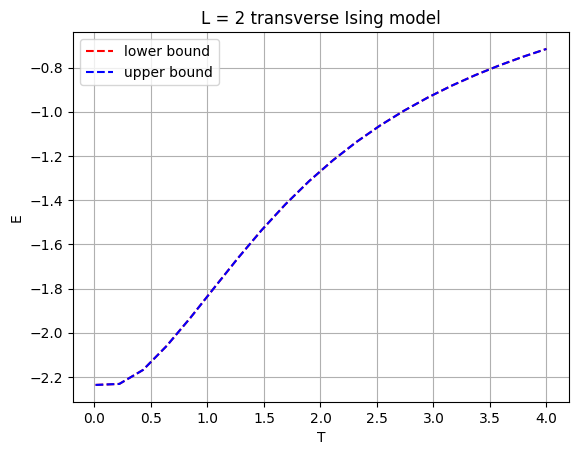

In [13]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound')
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid()
plt.show()

<h2>Directly in QICS:</h2>

In [3]:
class BasisReduction():
    def __init__(self, A, b):
        self._A = A.copy()
        self._b = b.copy()
        self._Arref, self._brref = Matrix(A).rref_rhs(Matrix(b))
        self._pivots = Matrix(A).rref()[1]
        self._free = sorted(list(set(range(A.shape[1])) - set(self._pivots))) # This is with the original numbering
        self._sz = len(self._free)
        self._reductions = [[Counter(), 0.0] for _ in range(A.shape[1])]
        self._init_free() # Initialize mappings for free variables
        self._generate_reductions() # Initialize mappings for pivot variables

    def _init_free(self):
        for i, p in enumerate(self._free):
            self._reductions[p][0][i] += 1.0
            self._reductions[p][1] = 0.0
    
    def _generate_reductions(self):
        crow = len(self._pivots) - 1
        for pcol in reversed(self._pivots):
            # Create mapping
            self._reductions[pcol][1] += np.double(self._brref[crow])
            for ccol in range(pcol + 1, self._A.shape[1]):
                if not np.isclose(self._Arref[crow, ccol], 0.0):
                    coeff = np.double(-self._Arref[crow, ccol]) # minus sign to transfer to other side of equality
                    self._reductions[pcol][1] += coeff * self._reductions[ccol][1]
                    for freew, c in self._reductions[ccol][0].items():
                        self._reductions[pcol][0][freew] += coeff * c
            # Update currow
            crow -= 1

    def size(self):
        return self._sz

    def reduce(self, p):
        # Return a mapping of the p-th element of the original basis
        # to a linear combination + constant offset of the new basis
        # Remember to take care of the numbering
        return self._reductions[p]

In [4]:
def schwinger_dyson(basis, n, hamil: list, word1: str):
    C = np.zeros((1, n))
    expression = Counter()
    for coeff, w in hamil:
        terms = commutator(w, word1)
        for op, c in terms.items():
            if len(op) != len(word1):
                continue
            expression[op] += coeff * c
    for op, c in expression.items():
        C[0, basis.rank(op)] += c
    return C

def get_A_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops1, ops2)
    return coeff, basis.rank(word)

def get_B_term(basis, i, j):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    coeff, word = product(ops2, ops1)
    return coeff, basis.rank(word)

def get_C_term(basis, i, j, hamil):
    ops1 = basis.unrank(i)
    ops2 = basis.unrank(j)
    termsd = Counter()
    for coeff, w in hamil:
        terms = commutator(w, ops2)
        for op, c in terms.items():
            if len(op) != len(w):
                continue
            c2, op2 = product(ops1, op)
            termsd[basis.rank(op2)] += coeff * c * c2 * 1j
    return termsd

In [5]:
def construct_hamil(L, h):
    hamil = []
    for i in range(L):
        t1 = None
        if i<L-1:
            t1 = 'I'*i + 'XX' + 'I'*(L-i-2)
        else:
            t1 = 'X' + 'I'*(L-2) + 'X'
        t2 = 'I'*i+'Z'+'I'*(L-i-1)
        hamil.extend([(-1, t1), (-h, t2)])
    if L == 2:
        hamil = [(-h, 'IZ'), (-h, 'ZI'), (-1, 'XX')]
    return hamil

def construct_lin(L, basis, hamil):
    n = basis.size()
    cons = [np.zeros((1, n))]
    cons[0][0, basis.rank('I' * L)] = 1.0
    for i in range(1, n):
        cons.append(schwinger_dyson(basis, n, hamil, basis.unrank(i)))
    A = np.vstack(cons)
    b = np.zeros((A.shape[0], 1))
    b[0, 0] = 1.0 # Normalization
    return A, b

def construct_cone(redbas, basis, hamil):
    # Construct beta * C, A, B, in that order, noting splitting and vectorization
    # Separate out the beta * C part and the A, B part so that later we just do
    # np.vstack([beta * G_betaC, G_AB])
    n2 = basis.size()
    n = redbas.size()
    G_betaC = np.zeros((2 * n2 * n2, n))
    G_A = np.zeros((2 * n2 * n2, n))
    G_B = np.zeros((2 * n2 * n2, n))
    hA = np.zeros((2 * n2 * n2, 1))
    hB = np.zeros((2 * n2 * n2, 1))
    hC = np.zeros((2 * n2 * n2, 1))
    for i in range(n2):
        for j in range(n2):
            # c might be complex, but there is only one p, which is the real expectation value
            # So complicated...
            # G[i, j] = sum over (cr + i cc) * (constr + sum over (c2r + i c2c) redword[b])
            # G[i, j]r = cr * constr + sum over (cr c2r - cc c2c) redword[b]
            # G[i, j]c = cc * constr + sum over (cr c2c + cc c2r) redword[b]
            # G_A
            c, p2 = get_A_term(basis, i, j)
            rewr, constr = redbas.reduce(p2)
            cr, cc = np.real(c), np.imag(c)
            hA[2 * n2 * i + 2 * j, 0] += cr * constr
            hA[2 * n2 * i + 2 * j + 1, 0] += cc * constr
            for p, c2 in rewr.items():
                G_A[2 * n2 * i + 2 * j, p] += cr * c2
                G_A[2 * n2 * i + 2 * j + 1, p] += cc * c2
            # G_B
            c, p2 = get_B_term(basis, i, j)
            rewr, constr = redbas.reduce(p2)
            cr, cc = np.real(c), np.imag(c)
            hB[2 * n2 * i + 2 * j, 0] += cr * constr
            hB[2 * n2 * i + 2 * j + 1, 0] += cc * constr
            for p, c2 in rewr.items():
                G_B[2 * n2 * i + 2 * j, p] += cr * c2
                G_B[2 * n2 * i + 2 * j + 1, p] += cc * c2
            # G_C
            termsd = get_C_term(basis, i, j, hamil)
            for p2, c in termsd.items():
                rewr, constr = redbas.reduce(p2)
                cr, cc = np.real(c), np.imag(c)
                hC[2 * n2 * i + 2 * j, 0] += cr * constr
                hC[2 * n2 * i + 2 * j + 1, 0] += cc * constr
                for p, c2 in rewr.items():
                    G_betaC[2 * n2 * i + 2 * j, p] += cr * c2
                    G_betaC[2 * n2 * i + 2 * j + 1, p] += cc * c2
    return G_betaC, np.vstack([G_A, G_B]), hC, np.vstack([hA, hB])

# Remember that all expectation values are real in the Ising model
def create_problem(L):
    basis = SiteBasis(L)
    n = basis.size()
    H = construct_hamil(L, 1)
    A, b = construct_lin(L, basis, H)
    redbas = BasisReduction(A, b)
    G_betaC, G_AB, h_betaC, h_AB = construct_cone(redbas, basis, H)
    c = np.zeros((redbas.size(), 1))
    offset = 0
    for coeff, word in H:
        # rew will be a dict with mapping {rank in reduced basis: coefficient}
        p2 = basis.rank(word)
        rew, const = redbas.reduce(p2)
        offset += coeff * const
        for p, c2 in rew.items():
            c[p, 0] += coeff * c2
    G_betaC = coo_array(G_betaC)
    G_AB = coo_array(G_AB)
    # h_betaC = coo_array(h_betaC)
    # h_AB = coo_array(h_AB)
    # c = csr_array(c)
    cones = [OpPerspecEpi(n, func="log", iscomplex=True)]
    return G_betaC, G_AB, h_betaC, h_AB, c, offset, cones, redbas

def solve(L, betas, verbose=True):
    mins, maxs = np.zeros_like(betas), np.zeros_like(betas)
    G_betaC, G_AB, h_betaC, h_AB, c, offset, cones, redbas = create_problem(L)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        # Note the sign for G, since QICS requires h - Gx in K
        # G = np.vstack([G_betaC, G_AB / beta])
        # h = np.vstack([h_betaC, h_AB / beta])
        # G = np.vstack([beta * G_betaC, G_AB])
        h = np.vstack([beta * h_betaC, h_AB])
        G = block_array([[beta * G_betaC], [G_AB]])
        # h = block_array([[beta * h_betaC], [h_AB]])
        minmodel = qc.Model(c=c, G=-G, h=h, cones=cones, offset=offset)
        maxmodel = qc.Model(c=-c, G=-G, h=h, cones=cones, offset=-offset)
        minsolver = qc.Solver(minmodel, verbose=0)
        maxsolver = qc.Solver(maxmodel, verbose=0)
        mininfo = minsolver.solve()
        maxinfo = maxsolver.solve()
        E_min = mininfo['p_obj']
        E_max = -maxinfo['p_obj']
        if verbose:
            print(f'\tE_min = {E_min}')
            print(f'\tE_max = {E_max}')
        mins[i], maxs[i] = E_min, E_max
    return mins, maxs


In [24]:
betas = 1/np.linspace(0.01, 4, num = 10)
L = 2
mins, maxs = solve(L, betas)

Solving for T=0.01, i=0:
	E_min = -2.2360679834059307
	E_max = -2.2360679811309536
Solving for T=0.45333333333333337, i=1:
	E_min = -1.3131419867745828
	E_max = -0.9236043967476992
Solving for T=0.8966666666666666, i=2:
	E_min = -1.0380059865903604
	E_max = -1.8052265876237683
Solving for T=1.34, i=3:
	E_min = -0.6849673353553587
	E_max = -0.9648100609167433
Solving for T=1.7833333333333334, i=4:
	E_min = -1.0502052955098768
	E_max = -0.60298218580634
Solving for T=2.2266666666666666, i=5:
	E_min = -0.34011019336168935
	E_max = -0.9711617488793742
Solving for T=2.67, i=6:
	E_min = -1.0155663566295021
	E_max = -0.0
Solving for T=3.1133333333333333, i=7:
	E_min = -0.5027901163882257
	E_max = -0.8475170325865665
Solving for T=3.556666666666666, i=8:
	E_min = -0.2877147822039001
	E_max = -0.038185898101861876
Solving for T=4.0, i=9:
	E_min = -0.05967805951106591
	E_max = -0.02517469211907075


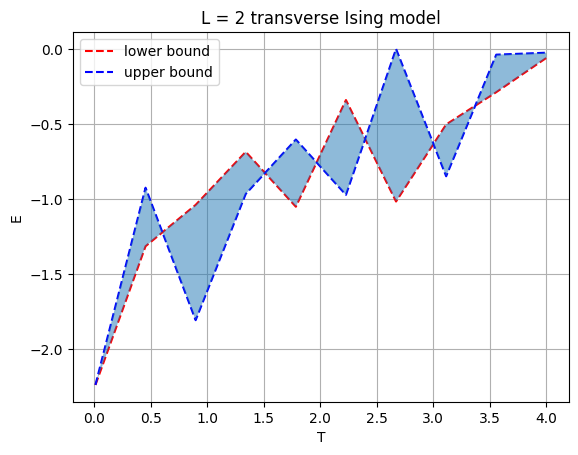

In [25]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5, zorder = 3)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound', zorder = 2)
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound', zorder = 2)
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid(zorder = 1)
plt.show()